# Measuring Neutrino Mass

Despite the neutrino being the most abundant (matter) particle in the universe we still do not know one of its fundamental characteristics, its mass. Neutrino oscillation experiments have proven definitively that neutrinos must have mass (otherwise they would not be able to change flavour via quantum mechanical mixing), but the absolute value of the mass is almost completely unknown.

## How do we measure the neutrino mass?

Way back in the 1930s Enrico Fermi (who named the neutrino) was the first to suggest a way of measuring the neutrino mass. His solution was to look at the energy of electrons coming from beta decay.

![Fermi's Beta decay sketch showing the effect of light or heavy neutrinos.](https://www.hep.ucl.ac.uk/undergrad/0056/other/projects/cres/fermiBetaSpectrum.png "Fermi's Beta Decay Sketch")


## So we can measure the electron energy, but how do we do that?

One of the most promising techniques for measuring the neutrino mass is called cyclotron radiation emission spectroscopy (CRES). In this process an electron with kinetic energy $T$ is placed in a magentic field and the electron undergoes cyclotron motion about the magnetic field lines. 

### Cyclotron radiation
The angular cyclotron frequency, $\omega_c$, of an electron with kinetic energy $T$ and mass $m_{e}$ in a magnetic field $B$ is
$$ \omega_{C} = \frac{eB}{\gamma m_e}=\frac{eB}{m_e + T/c^2} $$
The cyclotron frequency $f_c$ is related to the angular cyclotron frequency in the usual fashion.
$$ f_c = \frac{\omega_c}{2 \pi} $$

Since a charge moving in a circle is continually accelerating, and accelerating charges radiate, we can measure the energy of the electron by measuring the frequency of the emitted radiation.

### Data description
In the code below we will show you two datasets that represent (simulated) electrons in a magnetic field.

1. In one data set you will find the voltage signals that you might see on an oscilloscope attached to the antenna that is observing the cyclotron radiation emission. So this is just a time series of voltage values.
2. In the other data set you will find spectogram pictures which show the frequency as a function of time, in practice these images are calcuable from the voltage time series data.

In addition there is some meta data for each waveform-spectrogram pair describing the sumlated chirp in terms of start time, initial frequency, frequency slope, simulated [noise temperature](https://en.wikipedia.org/wiki/Noise_temperature) and signal collection efficiency (directly proportional to amplitude.

## Machine learning tasks
1. Write a machine learning method to determine the start frequency and time of a chirp from the spectrogram data.
2. Write a machine learning method to determine the start frequency and time of a chirp from the time series data.
3. Write a machine learning method to determine the start frequency and time of a chirp using both the spectrogram and time series data.

How does the frequency resolution (e.g. the difference or standard deviation of measured frequency - true frequency from the meta data) depends on the simulated noise temperature or chrip 'slope'?

### Potential optional extensions
1. Generate your own data (using the functions in the cres.ipynb notebook) to investigate how the frequency resolution (e.g. the standard deviation of measured frequency - true frequency from the meta data) depends on the simulated collection efficiency




In [1]:
# Import some libraries needed for the notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm



# importing what i need
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GRU, concatenate, GlobalAveragePooling2D, GlobalAveragePooling1D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# import the urllib library
import urllib.request
import os #For checking if a file exists
 
# Copy a network object to a local file
spectName="cresSpect0.npy"
waveName="cresWave0.npy"
metaName="cresSpectMeta0.csv"

#Now download the first waveform (time series) and spectrogram files
if not os.path.isfile(waveName):
    urllib.request.urlretrieve('https://www.hep.ucl.ac.uk/undergrad/0056/other/projects/cres/data/'+waveName, waveName)
if not os.path.isfile(spectName):
    urllib.request.urlretrieve('https://www.hep.ucl.ac.uk/undergrad/0056/other/projects/cres/data/'+spectName, spectName)
if not os.path.isfile(metaName):
    urllib.request.urlretrieve('https://www.hep.ucl.ac.uk/undergrad/0056/other/projects/cres/data/'+metaName, metaName)

#This is bad practice to download a file from the web and then load it, but you will just have to trust me.
images=np.load(spectName)
waves=np.load(waveName)
#And read in the meta data
df=pd.read_csv('cresSpectMeta0.csv') 
df.describe()

t0s           f0s           c0s           Ts     eps
count  1.000000e+03  1.000000e+03  1.000000e+03  1000.000000  1000.0
mean   5.032932e-04  2.496827e+07  3.994796e+08    54.672031     1.0
std    2.825682e-04  2.868214e+06  2.914911e+07    14.380851     0.0
min    1.786889e-07  2.001269e+07  3.500023e+08    30.001260     1.0
25%    2.616261e-04  2.263746e+07  3.728228e+08    42.698587     1.0
50%    5.083216e-04  2.498980e+07  3.995212e+08    55.370072     1.0
75%    7.411566e-04  2.737261e+07  4.238753e+08    67.221612     1.0
max    9.999834e-04  2.998791e+07  4.497193e+08    79.953869     1.0

## Quick look at data
The code below will extract an event and plot the waveform and spectrogram

Looking at Event 0
t0s    5.562189e-05
f0s    2.686778e+07
c0s    4.468855e+08
Ts     6.619622e+01
eps    1.000000e+00
Name: 0, dtype: float64
waves.shape (1000, 200000)
images.shape (1000, 600, 100)


Text(0.5, 1.0, 'Event 0, T=66.2K, t0=5.6e-02ms, f0=26.9MHz,c0=0.4MHz/ms ')

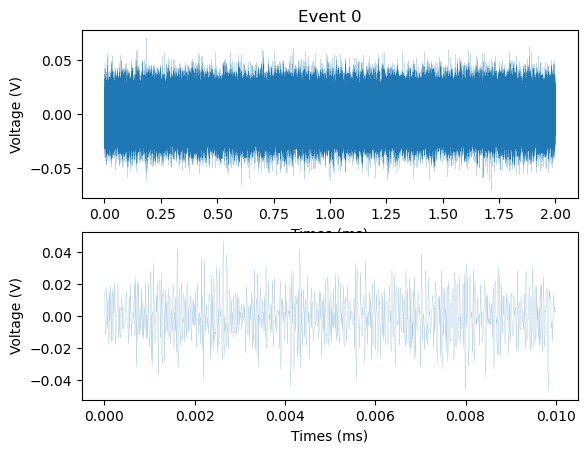

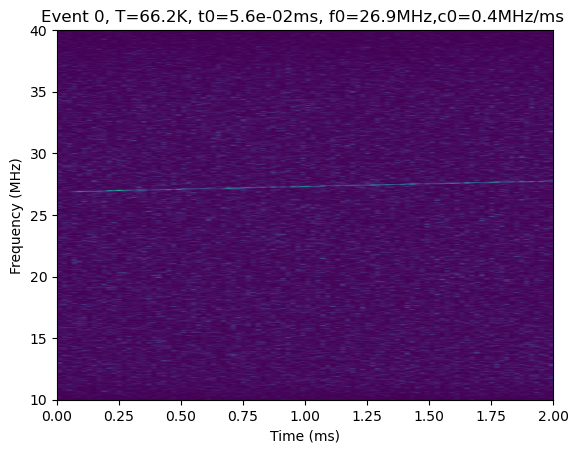

In [3]:
# The times that go with the voltage values
N=len(waves[0]) #200,000 numbers
dt=1e-8 #100MSa/s
dt = dt * 1e3 # Convert seconds to milliseconds
t=np.linspace(0,dt*(N-1),N) #Time array
whichEvent=0


print("Looking at Event {i}".format(i=whichEvent))
print(df.iloc[whichEvent])
print("waves.shape",waves.shape) #1000 events, 200000 numbers per event
print("images.shape",images.shape) #1000 events, 600x100 images 600 frequency bins, 100 time slices


fig,ax = plt.subplots(2,1)
ax[0].plot(t,waves[whichEvent], linewidth=0.1)  # Plot voltage v time
ax[0].set_xlabel("Times (ms)")
ax[0].set_ylabel("Voltage (V)")
ax[0].set_title("Event {ind}".format(ind=whichEvent))
ax[1].plot(t[0:1000],waves[whichEvent][0:1000], linewidth=0.1)  # Zoomed plot voltage v time
ax[1].set_xlabel("Times (ms)")
ax[1].set_ylabel("Voltage (V)")

fig,ax = plt.subplots()
ax.imshow(images[whichEvent],extent=[0,2,10,40],aspect='auto',origin='lower')
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Frequency (MHz)")
titleStr='Event {ind}, T={T:.1f}K, t0={t0:.1e}ms, f0={f0:.1f}MHz,c0={c0:.1f}MHz/ms '.format(
        ind=whichEvent, 
        T=df['Ts'][whichEvent],
        t0=df['t0s'][whichEvent]*1e3, #s->ms
        f0=df['f0s'][whichEvent]/1e6, #Hz->MHz
        c0=df['c0s'][whichEvent]/1e9)  #Hz/s  ->Mhz/ms
ax.set_title(titleStr)

# MINI-PROJECT BEINGS HERE:

## Introduction:
This notebook seeks to create three machine learning models to extract and predict data using Cyclotron Radiation Emission Spectroscopy (CRES) data in the form of both time series data and spectrograms. Due to 'dirty data' Task 2 has employed a series of models to try tackle the task at hand however reaches a noise floor. The data has also notably affected Task 3.

# Machine Learning Task 1:
Write a machine learning method to determine the start frequency and time of a chirp from the spectrogram data.

### Model and Training:
- This model takes around 5mins to run. Please be patient. 


In [4]:
# 'df' and 'images' loaded already
images_normalized = images / np.max(images)

# Standardising labels
scaler_t0s = StandardScaler()
scaler_f0s = StandardScaler()

labels_t0s_scaled = scaler_t0s.fit_transform(df[['t0s']])
labels_f0s_scaled = scaler_f0s.fit_transform(df[['f0s']])

# Splitting the standardised labels into training and testing sets
X_train, X_test, y_train_t0s, y_test_t0s = train_test_split(images_normalized, labels_t0s_scaled, test_size=0.15, random_state=42)
_, _, y_train_f0s, y_test_f0s = train_test_split(images_normalized, labels_f0s_scaled, test_size=0.15, random_state=42)

# Reshaping the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Model architecture with L2 regularization and Batch Normalization
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
batch1 = BatchNormalization()(pool1)
drop1 = Dropout(0.25)(batch1)

conv2 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(drop1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
batch2 = BatchNormalization()(pool2)
drop2 = Dropout(0.25)(batch2)

conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(drop2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
batch3 = BatchNormalization()(pool3)
drop3 = Dropout(0.25)(batch3)

flat = Flatten()(drop3)
dense1 = Dense(128, activation='relu')(flat)
drop4 = Dropout(0.5)(dense1)

output_t0s = Dense(1, name='start_time')(drop4)
output_f0s = Dense(1, name='start_freq')(drop4)

model1b = Model(inputs=input_layer, outputs=[output_t0s, output_f0s])

# Learning rate and optimiser
learning_rate = 0.0001
adam_optimiser = Adam(learning_rate=learning_rate)

model1b.compile(optimizer=adam_optimiser,
               loss={'start_time': 'mse', 'start_freq': 'mse'},
               metrics={'start_time': 'mse', 'start_freq': 'mse'})

# Training the model with callback
history1b = model1b.fit(X_train,
                     {'start_time': y_train_t0s, 'start_freq': y_train_f0s},
                     validation_data=(X_test, {'start_time': y_test_t0s, 'start_freq': y_test_f0s}),
                     epochs=50,
                     batch_size=6)


# Evaluating the model
eval_results = model1b.evaluate(X_test, {'start_time': y_test_t0s, 'start_freq': y_test_f0s})
print(f"Evaluation results: {eval_results}")

Epoch 1/50
142/142 [==============================] - 9s 59ms/step - loss: 8.4594 - start_time_loss: 4.3512 - start_freq_loss: 3.4517 - start_time_mse: 4.3512 - start_freq_mse: 3.4517 - val_loss: 3.5597 - val_start_time_loss: 1.5395 - val_start_freq_loss: 1.3638 - val_start_time_mse: 1.5395 - val_start_freq_mse: 1.3638
Epoch 2/50
142/142 [==============================] - 8s 59ms/step - loss: 2.4993 - start_time_loss: 1.1161 - start_freq_loss: 0.7270 - start_time_mse: 1.1161 - start_freq_mse: 0.7270 - val_loss: 4.5134 - val_start_time_loss: 2.8166 - val_start_freq_loss: 1.0409 - val_start_time_mse: 2.8166 - val_start_freq_mse: 1.0409
Epoch 3/50
142/142 [==============================] - 9s 60ms/step - loss: 2.1371 - start_time_loss: 0.9763 - start_freq_loss: 0.5052 - start_time_mse: 0.9763 - start_freq_mse: 0.5052 - val_loss: 12.0305 - val_start_time_loss: 4.0662 - val_start_freq_loss: 7.3091 - val_start_time_mse: 4.0662 - val_start_freq_mse: 7.3091
Epoch 4/50
142/142 [================

5/5 [==============================] - 0s 55ms/step - loss: 1.3499 - start_time_loss: 0.7836 - start_freq_loss: 0.1009 - start_time_mse: 0.7836 - start_freq_mse: 0.1009
Evaluation results: [1.34990394115448, 0.7836089134216309, 0.10086686164140701, 0.7836089134216309, 0.10086686164140701]


### Plotting the Losses

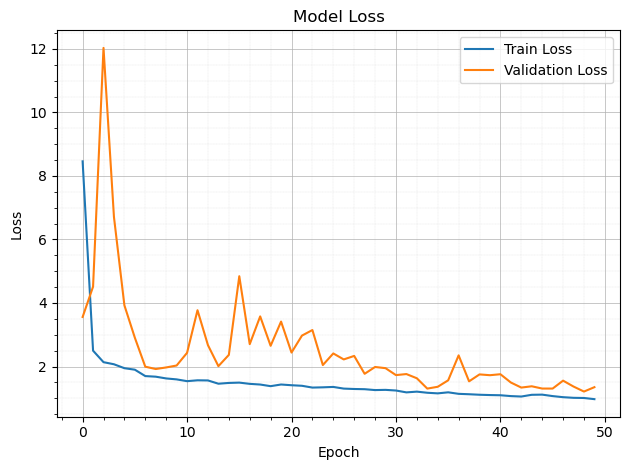

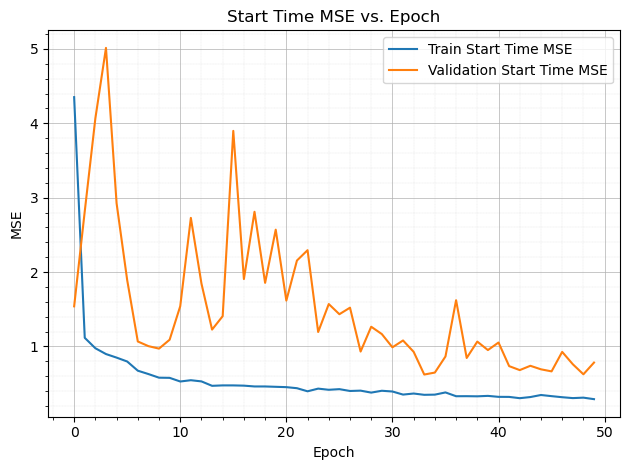

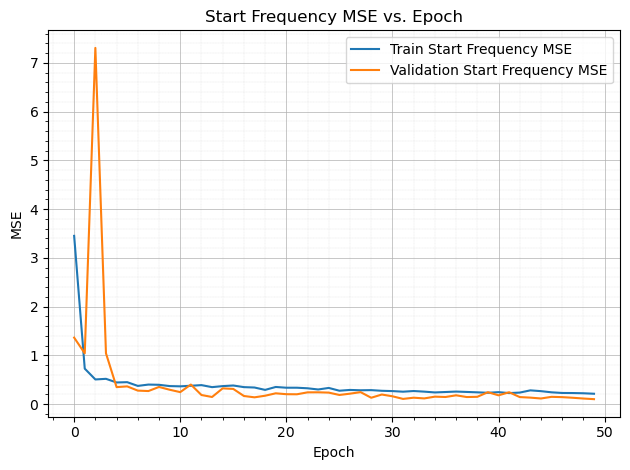

In [5]:
# Plot training & validation loss values
plt.plot(history1b.history['loss'], label='Train Loss')
plt.plot(history1b.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.tight_layout()
plt.show()

plt.plot(history1b.history['start_time_mse'], label='Train Start Time MSE')
plt.plot(history1b.history['val_start_time_mse'], label='Validation Start Time MSE')
plt.title('Start Time MSE vs. Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.tight_layout()
plt.show()

plt.plot(history1b.history['start_freq_mse'], label='Train Start Frequency MSE')
plt.plot(history1b.history['val_start_freq_mse'], label='Validation Start Frequency MSE')
plt.title('Start Frequency MSE vs. Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.tight_layout()
plt.show()

## PREDICTIONS

1/1 [==============================] - 0s 12ms/step


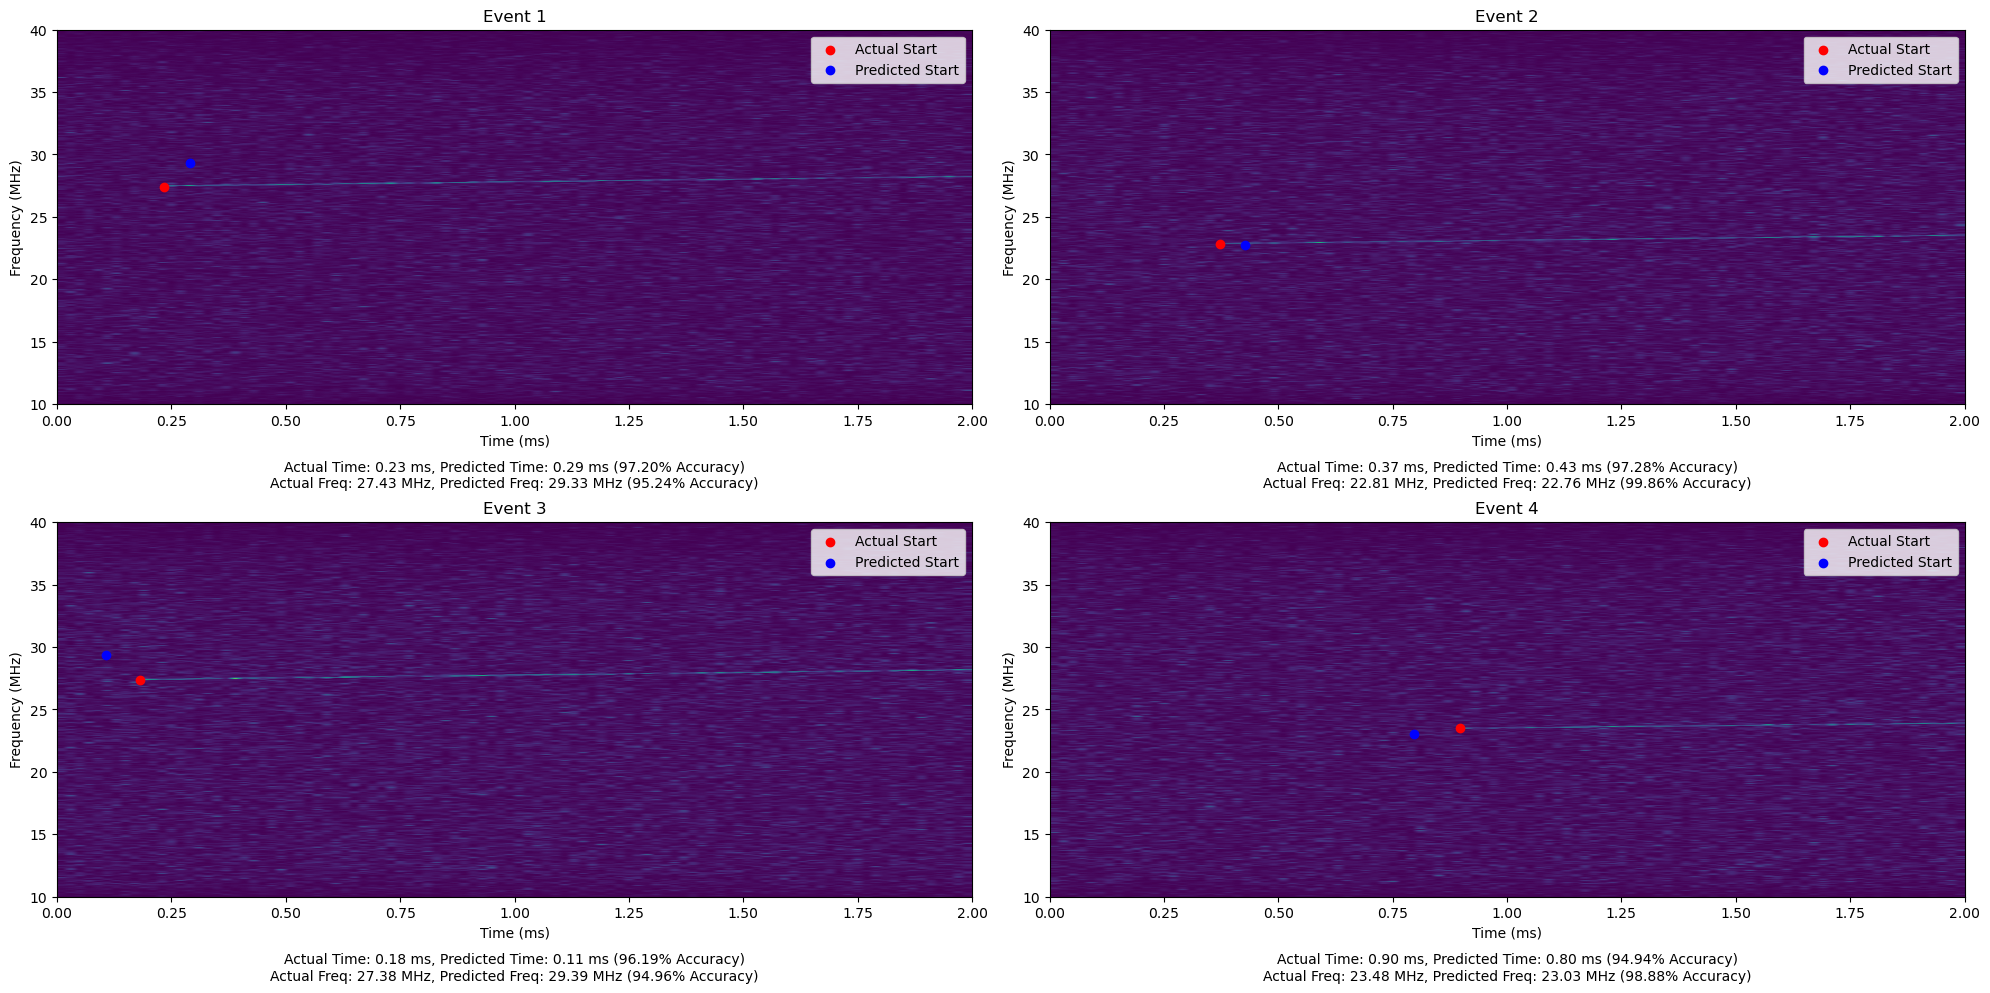

In [6]:
# Load the new spectrogram and metadata, this new data will test if the model can predict or if it just memorises the data
spectrogram_new = np.load('cresSpect2.npy')  
metadata_new = pd.read_csv('cresSpectMeta2.csv')  



# Number of events to predict and plot
num_events = 4

# Prepare subplot grid with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Flatten the array
axs = axs.ravel()

for whichEvent in range(num_events):
    spectrogram_to_predict = spectrogram_new[whichEvent] / np.max(spectrogram_new[whichEvent])
    spectrogram_to_predict_reshaped = spectrogram_to_predict.reshape(1, spectrogram_to_predict.shape[0], spectrogram_to_predict.shape[1], 1)
    
    predictions_new = model1b.predict(spectrogram_to_predict_reshaped)
    predicted_t0s_new = scaler_t0s.inverse_transform(predictions_new[0])
    predicted_f0s_new = scaler_f0s.inverse_transform(predictions_new[1])
    
    predicted_t0s_ms_new = predicted_t0s_new[0][0] * 1e3
    predicted_f0s_MHz_new = predicted_f0s_new[0][0] / 1e6
    
    actual_t0s_new = metadata_new['t0s'][whichEvent] * 1e3
    actual_f0s_new = metadata_new['f0s'][whichEvent] / 1e6
    
   # Calculate accuracy percentages
    tdelta = np.abs(((predicted_t0s_ms_new-actual_t0s_new) / 2 * 100))
    fdelta = np.abs(((predicted_f0s_MHz_new-actual_f0s_new) / 40 * 100))
    
    time_accuracy = 100 - tdelta
    freq_accuracy = 100 - fdelta
    
    # Annotate the actual and predicted start times and frequencies along with the accuracy
    text_to_display = (f'Actual Time: {actual_t0s_new:.2f} ms, Predicted Time: {predicted_t0s_ms_new:.2f} ms '
                       f'({time_accuracy:.2f}% Accuracy)\n'
                       f'Actual Freq: {actual_f0s_new:.2f} MHz, Predicted Freq: {predicted_f0s_MHz_new:.2f} MHz '
                       f'({freq_accuracy:.2f}% Accuracy)')
    
    # Plot both actual and predicted starts
    ax = axs[whichEvent]
    ax.imshow(spectrogram_new[whichEvent], extent=[0, 2, 10, 40], aspect='auto', origin='lower')
    ax.scatter(actual_t0s_new, actual_f0s_new, color='red', label='Actual Start')
    ax.scatter(predicted_t0s_ms_new, predicted_f0s_MHz_new, color='blue', label='Predicted Start')
    ax.set_title(f'Event {whichEvent + 1}')
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Frequency (MHz)")
    ax.text(0.5, -0.15, text_to_display, ha='center', va='top', transform=ax.transAxes, fontsize=10)

axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")
axs[2].legend(loc="upper right")
axs[3].legend(loc="upper right")

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

# Machine Learning Task 2

Write a machine learning method to determine the start frequency and time of a chirp from the time series data.

[[ 0.01580263 -0.0120308  -0.01608979 ...  0.00556453  0.02782228
  -0.01237392]
 [-0.01768735 -0.01565759 -0.01105291 ... -0.02160556  0.0110255
   0.03089273]
 [-0.02772551 -0.01685473  0.01955345 ... -0.00858956 -0.00305134
   0.01701781]
 ...
 [ 0.01624357 -0.0155677  -0.00069999 ...  0.00810126 -0.00656261
   0.00601289]
 [ 0.02257659 -0.03462486 -0.01978864 ... -0.01529227  0.00755525
   0.02520969]
 [ 0.01725014 -0.02294076 -0.02789754 ... -0.04474829 -0.02858959
   0.03801417]]
[[ 0.01580263 -0.0120308  -0.01608979 ...  0.00556453  0.02782228
  -0.01237392]
 [-0.01768735 -0.01565759 -0.01105291 ... -0.02160556  0.0110255
   0.03089273]
 [-0.02772551 -0.01685473  0.01955345 ... -0.00858956 -0.00305134
   0.01701781]
 ...
 [ 0.00576677  0.02083581 -0.0373169  ...  0.01165195 -0.01800324
  -0.02087569]
 [ 0.00309489  0.01266107  0.00500314 ...  0.01622606 -0.0109319
   0.00062058]
 [ 0.00494078 -0.01184474 -0.00419146 ... -0.01077396  0.01624617
  -0.0088474 ]]


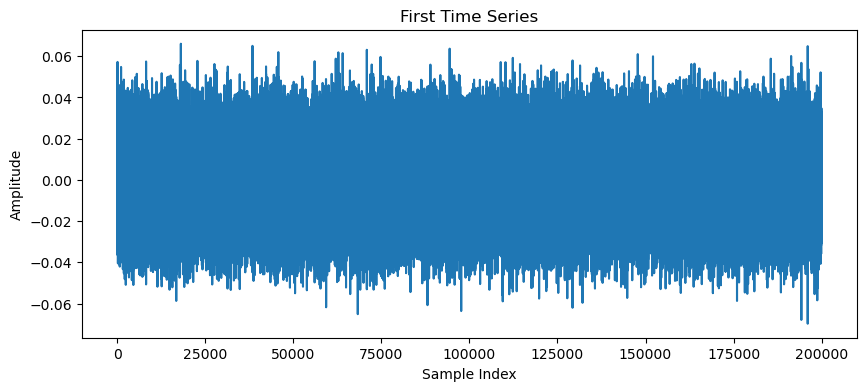

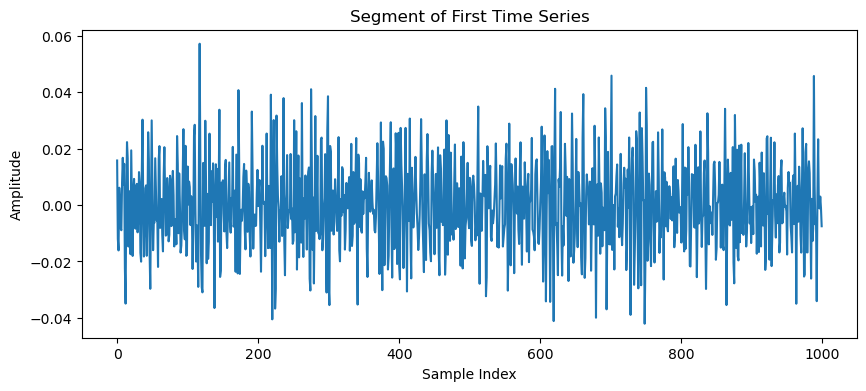

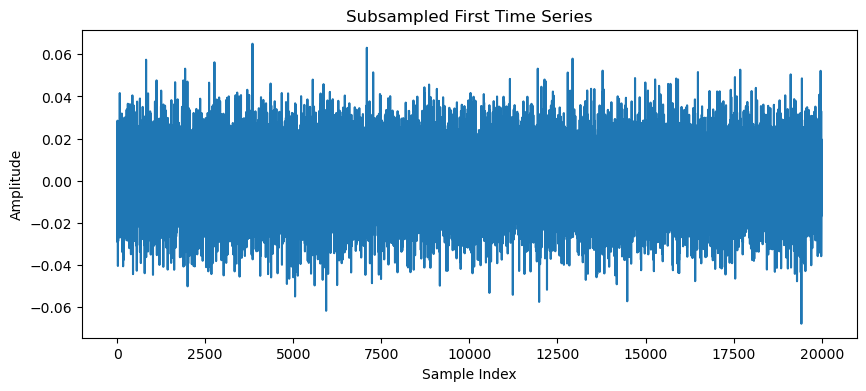

In [7]:
# In essence, this does not contribute towards the task.
## However, it contributed towards my understanding of the task so I've decided to include it.

file_path = 'cresWave3.npy'

# Load the .npy file
data = np.load(file_path)

# Print the loaded data
print(data)

# Portion of data
print(data[:10])  # Print the first 10 elements for a 1D array, or first 10 rows for a 2D array, etc.

# Plot the first time series
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
plt.plot(data[0])  # Assuming data[0] is a 1D array representing the first time series
plt.title('First Time Series')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()


# Plot the first 1000 samples of the first time series
plt.figure(figsize=(10, 4))
plt.plot(data[0][:1000])  # Adjust the range as needed
plt.title('Segment of First Time Series')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()



# Subsample the data: Plot every 10th point of the first time series
n = 10
plt.figure(figsize=(10, 4))
plt.plot(data[0][::n])  # Takes every nth sample
plt.title('Subsampled First Time Series')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

## LSTM (RNN and preferred) model

In [8]:
# LSTM is too computationally difficult, please skip this cell, put in here to show the layout I would like to use.
'''
# Load the data and metadata
data_path = 'cresWave3.npy'
metadata_path = 'cresSpectMeta3.csv'
data = np.load(data_path)
metadata = pd.read_csv(metadata_path)

# Extract targets
targets = metadata[['t0s', 'f0s']].values

# Subset of data to reduce computational load
subset_size = 2 
indices = np.random.permutation(len(data))[:subset_size]
data_subset = data[indices]
targets_subset = targets[indices]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data_subset, targets_subset, test_size=0.2, random_state=42)

# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define LSTM
model = Sequential([
    LSTM(2, input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.1),
    LSTM(4, return_sequences=False),
    Dropout(0.1),
    Dense(8, activation='relu'),
    Dense(2, activation='linear') 
])

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

# Train
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32)

# Summarise
model.summary()

'''

"\n# Load the data and metadata\ndata_path = 'cresWave3.npy'\nmetadata_path = 'cresSpectMeta3.csv'\ndata = np.load(data_path)\nmetadata = pd.read_csv(metadata_path)\n\n# Extract targets\ntargets = metadata[['t0s', 'f0s']].values\n\n# Subset of data to reduce computational load\nsubset_size = 2 \nindices = np.random.permutation(len(data))[:subset_size]\ndata_subset = data[indices]\ntargets_subset = targets[indices]\n\n# Split the data\nX_train, X_test, y_train, y_test = train_test_split(data_subset, targets_subset, test_size=0.2, random_state=42)\n\n# Reshape data for LSTM\nX_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))\nX_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))\n\n# Define LSTM\nmodel = Sequential([\n    LSTM(2, input_shape=(X_train.shape[1], 1), return_sequences=True),\n    Dropout(0.1),\n    LSTM(4, return_sequences=False),\n    Dropout(0.1),\n    Dense(8, activation='relu'),\n    Dense(2, activation='linear') \n])\n\n# Compile\nmodel.compile(

## Model 1
This is a simple CNN with normalised input data and cutoff. It is not the correct model choice for time series data, however, due to the above LSTM model being too computationally difficult for this computer I have decided to run a model to show how it perfoms. It performs ok however takes a long time to run. 

- This model takes around 4 mins to run. 

In [9]:
# Load time series data and metadata
data_path = 'cresWave4.npy'
data = np.load(data_path)
metadata_path = 'cresSpectMeta4.csv'
metadata = pd.read_csv(metadata_path)

# Define cutoff (using 75th percentile as threshold)
cutoff = np.percentile(data, 75)

# Apply cutoff
data[data < cutoff] = 0

# Prepare targets from metadata
targets = metadata[['t0s', 'f0s']].values

# Normalise data and targets
scaler_X = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler_X.fit_transform(data.reshape(-1, data.shape[1])).reshape(data.shape)
scaler_y = MinMaxScaler(feature_range=(0, 1))
targets_normalized = scaler_y.fit_transform(targets)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_normalized, targets_normalized, test_size=0.2, random_state=42)

# Reshape
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


# Define model
model21 = Sequential([
    Conv1D(filters=16, kernel_size=6, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=6, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(targets.shape[1], activation='linear') 
])

# Creating the optimiser
optimiser_instance = Adam(learning_rate=2e-4)

# Compile
model21.compile(optimiser_instance, loss='mse')

# Train 
history21 = model21.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=16)

# Evaluate 
model21.summary()

Epoch 1/10
50/50 [==============================] - 27s 527ms/step - loss: 22.4577 - val_loss: 0.9755
Epoch 2/10
50/50 [==============================] - 27s 534ms/step - loss: 0.2976 - val_loss: 0.1469
Epoch 3/10
50/50 [==============================] - 32s 639ms/step - loss: 0.1629 - val_loss: 0.0864
Epoch 4/10
50/50 [==============================] - 28s 565ms/step - loss: 0.1201 - val_loss: 0.1024
Epoch 5/10
50/50 [==============================] - 26s 516ms/step - loss: 0.0929 - val_loss: 0.1230
Epoch 6/10
50/50 [==============================] - 26s 512ms/step - loss: 0.0780 - val_loss: 0.0919
Epoch 7/10
50/50 [==============================] - 25s 510ms/step - loss: 0.0461 - val_loss: 0.0832
Epoch 8/10
50/50 [==============================] - 25s 503ms/step - loss: 0.0307 - val_loss: 0.1005
Epoch 9/10
50/50 [==============================] - 56s 1s/step - loss: 0.0263 - val_loss: 0.1031
Epoch 10/10
50/50 [==============================] - 25s 502ms/step - loss: 0.0167 - val_loss

### Model 1 Loss Graphs
- This cell takes around 11-12 mins to run.

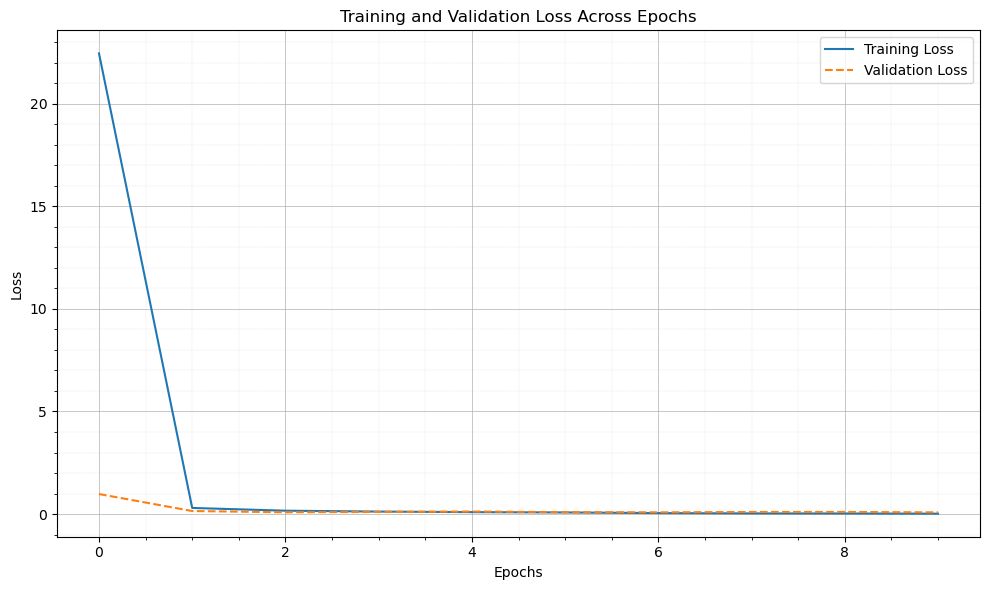

In [10]:
# Accessing the training loss and validation loss
training_loss = history21.history['loss']
validation_loss = history21.history['val_loss']

# Plotting both training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.tight_layout()
plt.show()



### Model 1 Predictions


7/7 [==============================] - 349s 283ms/step


/var/folders/yb/9r5zmsp91wg3c06sp_sdtcpw0000gp/T/ipykernel_69820/3103739758.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


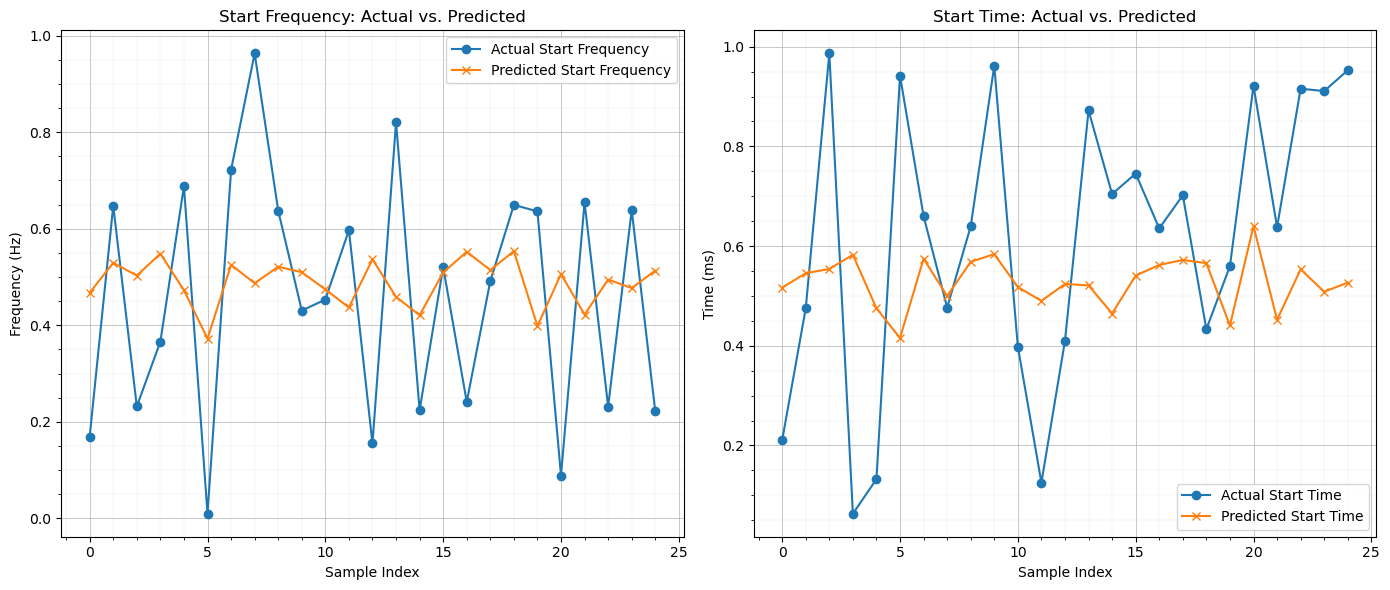

In [11]:
y_pred = model21.predict(X_test)

# Number of samples to display
n = 25  

# Simple index array
t = np.arange(n)

plt.figure(figsize=(14, 6))

# Plot actual vs. predicted start frequency
plt.subplot(1, 2, 1)
plt.plot(t, y_test[:n, 0], 'o-', label='Actual Start Frequency')
plt.plot(t, np.abs(y_pred[:n, 0]), 'x-', label='Predicted Start Frequency')
plt.title('Start Frequency: Actual vs. Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.tight_layout()

# Plot actual vs. predicted start time
plt.subplot(1, 2, 2)
plt.plot(t, y_test[:n, 1], 'o-', label='Actual Start Time')
plt.plot(t, y_pred[:n, 1], 'x-', label='Predicted Start Time')
plt.title('Start Time: Actual vs. Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Time (ms)')
plt.legend()
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.tight_layout()
plt.show()


## Model 2
- Complex CNN with standardised input data and data sub-sampling.
- This model takes around 3 mins to run. 

In [12]:
# Load data
data = np.load('cresWave5.npy')  
metadata = pd.read_csv('cresSpectMeta5.csv')

# Preprocessing
scaler = StandardScaler() # this model works better with standardisation
data_normalized = scaler.fit_transform(data.reshape(-1, data.shape[1])).reshape(data.shape)

# Prepare targets
targets = metadata[['t0s', 'f0s']].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(data_normalized, targets, test_size=0.2, random_state=42)

# Reshape data for Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define a simpler model
model22 = Sequential([
    Conv1D(32, 7, strides=2, activation='relu', input_shape=(X_train.shape[1], 1)),  
    MaxPooling1D(2),
    Conv1D(64, 5, strides=2, activation='relu'),  
    MaxPooling1D(2),
    Flatten(),
    Dense(32, activation='relu'),  
    Dense(2, activation='linear')  
])

# Compile
model22.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Reducing size of X_train and y_train by subsampling
X_train_subsampled = X_train[::2]  # subsample by taking every second sample
y_train_subsampled = y_train[::2]

# Train
history22 = model22.fit(X_train_subsampled, y_train_subsampled, epochs=20, validation_data=(X_test, y_test), batch_size=64)  # Adjusted batch size

# Evaluate
model22.evaluate(X_test, y_test)

Epoch 1/20
7/7 [==============================] - 8s 968ms/step - loss: 317050492813312.0000 - val_loss: 320502069460992.0000
Epoch 2/20
7/7 [==============================] - 7s 981ms/step - loss: 316906342973440.0000 - val_loss: 320223769001984.0000
Epoch 3/20
7/7 [==============================] - 7s 972ms/step - loss: 316512145506304.0000 - val_loss: 319580564094976.0000
Epoch 4/20
7/7 [==============================] - 7s 989ms/step - loss: 315673687359488.0000 - val_loss: 318323615072256.0000
Epoch 5/20
7/7 [==============================] - 8s 1s/step - loss: 314092434751488.0000 - val_loss: 316092647997440.0000
Epoch 6/20
7/7 [==============================] - 76s 12s/step - loss: 311373653344256.0000 - val_loss: 312400922279936.0000
Epoch 7/20
7/7 [==============================] - 9s 1s/step - loss: 306990907654144.0000 - val_loss: 306634962239488.0000
Epoch 8/20
7/7 [==============================] - 8s 948ms/step - loss: 300280491016192.0000 - val_loss: 298063415476224.0000

7820242059264.0

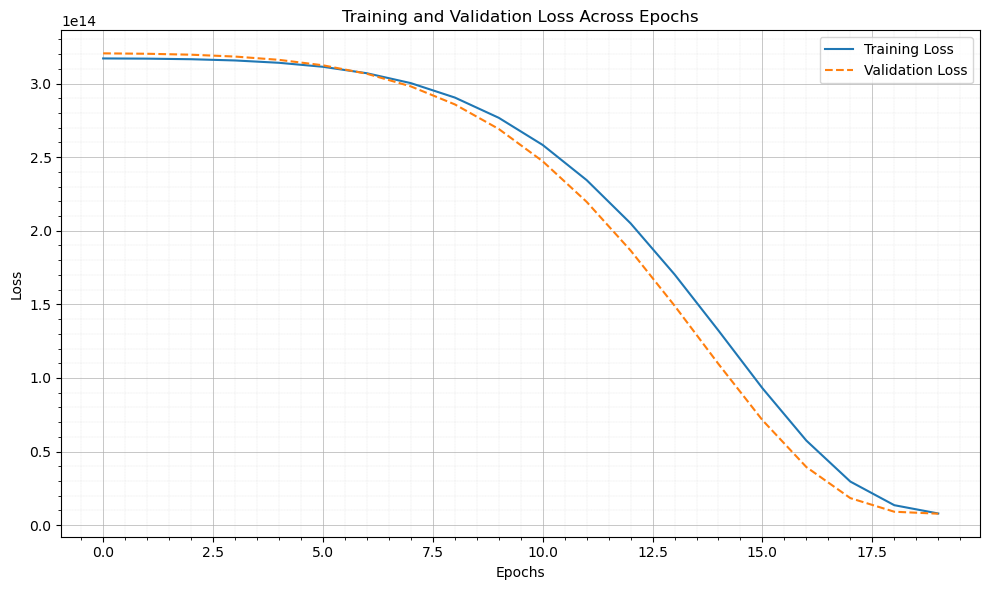

In [13]:
# Access training and validation loss
training_loss = history22.history['loss']
validation_loss = history22.history['val_loss']

# Plotting both training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.tight_layout()
plt.show()


## Predictions 

7/7 [==============================] - 1s 120ms/step


/var/folders/yb/9r5zmsp91wg3c06sp_sdtcpw0000gp/T/ipykernel_69820/484578042.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


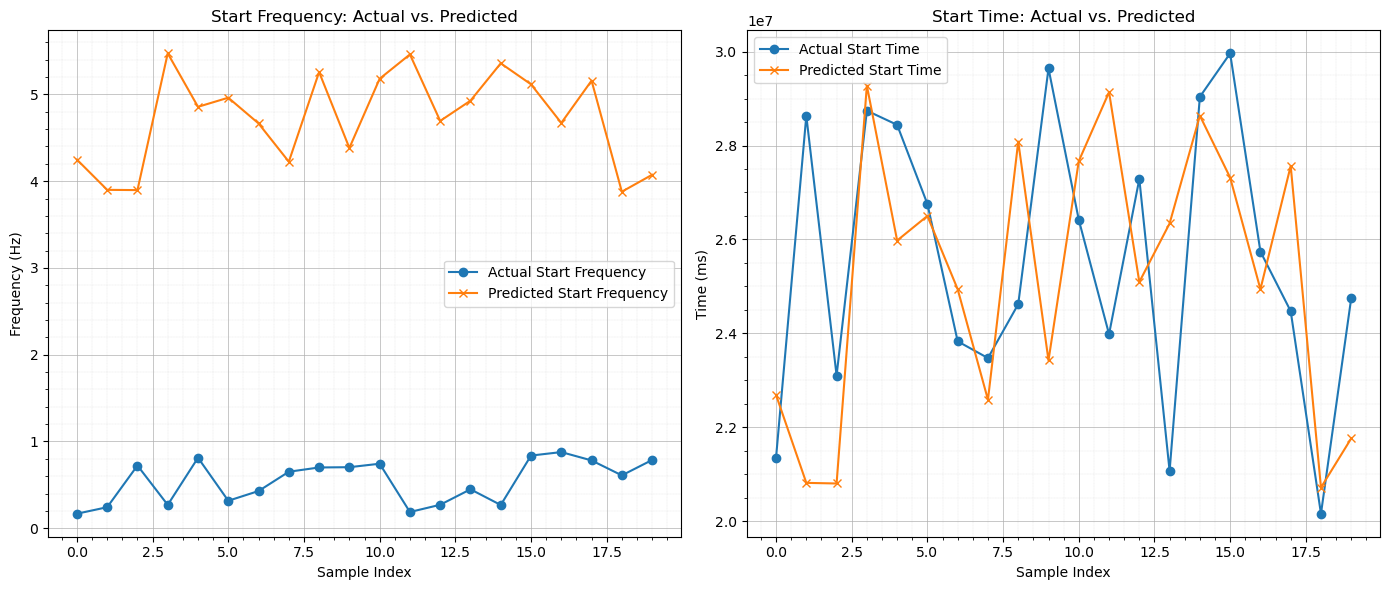

In [14]:
y_pred = model22.predict(X_test)

n = 20  # Number of samples to display
t = np.arange(n)  # index array

plt.figure(figsize=(14, 6))

# Plot actual vs. predicted start frequency
plt.subplot(1, 2, 1)
plt.plot(t, y_test[:n, 0]*1000, 'o-', label='Actual Start Frequency')
plt.plot(t, np.abs(y_pred[:n, 0])/1000, 'x-', label='Predicted Start Frequency')
plt.title('Start Frequency: Actual vs. Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.tight_layout()

# Plot actual vs. predicted start time
plt.subplot(1, 2, 2)
plt.plot(t, y_test[:n, 1], 'o-', label='Actual Start Time')
plt.plot(t, y_pred[:n, 1], 'x-', label='Predicted Start Time')
plt.title('Start Time: Actual vs. Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Time (ms)')
plt.legend()
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.tight_layout()
plt.show()


## Model 3: GRU model
- A version of an LSTM but has a much lower computational load.
- This model takes around 1-2mins to run.

In [15]:
# Load files
file_path = 'cresWave7.npy'
data = np.load(file_path)
df = pd.read_csv('cresSpectMeta7.csv') 

X = data
y = df[['t0s', 'f0s']].values

# Initialise scaler instances for input features and labels
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Normalise input
X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[1])).reshape(X.shape)

# Normalise labels
y_scaled = scaler_y.fit_transform(y)

# Split training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input for GRU
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define GRU model
model23 = Sequential([
    GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(2) 
])

# Compile
model23.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=5)

# Train
history23 = model23.fit(X_train, y_train, epochs=20, batch_size=164, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/20
4/4 [==============================] - 4s 556ms/step - loss: 0.8446 - val_loss: 0.4486
Epoch 2/20
4/4 [==============================] - 1s 303ms/step - loss: 0.2939 - val_loss: 0.0854
Epoch 3/20
4/4 [==============================] - 1s 327ms/step - loss: 0.1667 - val_loss: 0.2150
Epoch 4/20
4/4 [==============================] - 1s 271ms/step - loss: 0.2616 - val_loss: 0.2192
Epoch 5/20
4/4 [==============================] - 1s 240ms/step - loss: 0.2087 - val_loss: 0.1249
Epoch 6/20
4/4 [==============================] - 1s 232ms/step - loss: 0.1386 - val_loss: 0.0848
Epoch 7/20
4/4 [==============================] - 1s 223ms/step - loss: 0.1175 - val_loss: 0.0941
Epoch 8/20
4/4 [==============================] - 1s 227ms/step - loss: 0.1334 - val_loss: 0.0997
Epoch 9/20
4/4 [==============================] - 1s 230ms/step - loss: 0.1278 - val_loss: 0.0913
Epoch 10/20
4/4 [==============================] - 1s 228ms/step - loss: 0.1192 - val_loss: 0.0847
Epoch 11/20
4/4 [==

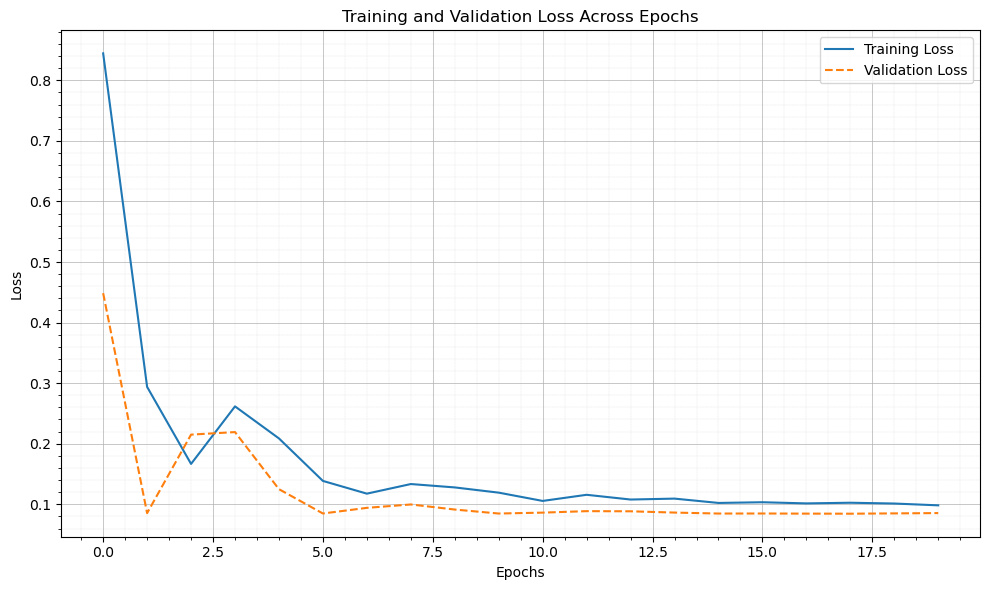

In [16]:
# Accessing training and validation loss
training_loss = history23.history['loss']
validation_loss = history23.history['val_loss']

# Plotting both training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 247ms/step


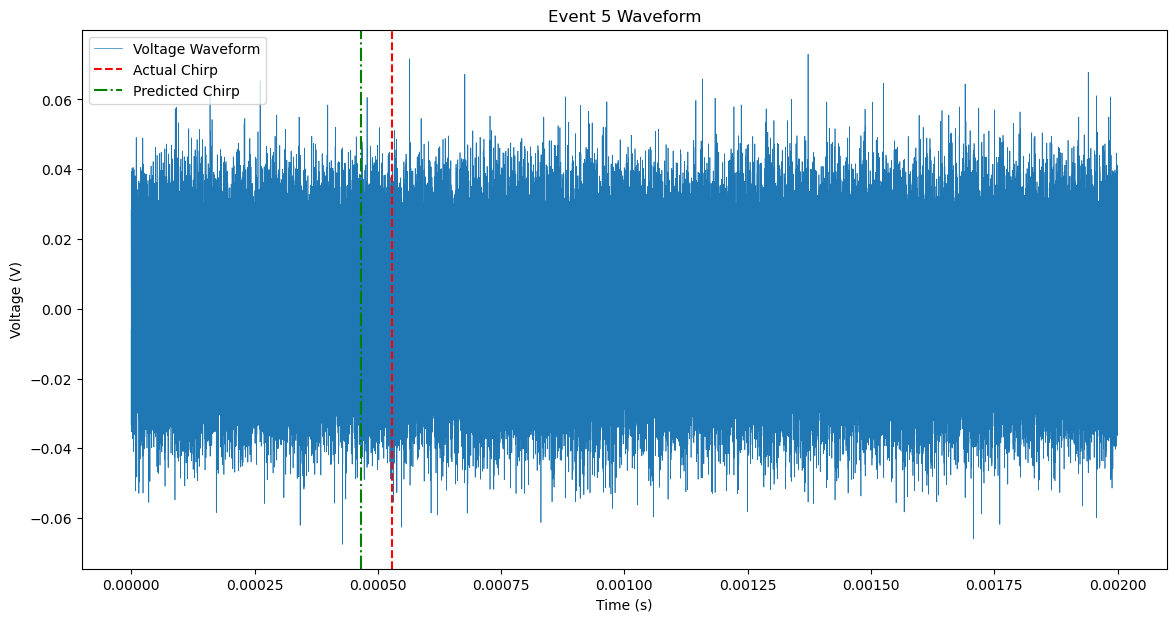

In [17]:
whichEvent = 5
X_event = data[whichEvent].reshape(1, -1) 
X_event_scaled = scaler_X.transform(X_event)  

# Reshape for GRU input requirements
X_event_scaled = X_event_scaled.reshape(1, 1, -1)

# Make predictions
predictions_scaled = model23.predict(X_event_scaled)

# Inverse transform predictions
predictions = scaler_y.inverse_transform(predictions_scaled)

# Time array for the entire dataset
dt = 1e-8
t = np.linspace(0, dt * data.shape[1], data.shape[1])

# Plotting the time vs voltage graph with actual and predicted chirps
plt.figure(figsize=(14, 7))
# Flatten X_event for plotting
plt.plot(t, X_event.flatten(), label='Voltage Waveform', linewidth=0.5)
plt.axvline(x=y[whichEvent][0], color='r', linestyle='--', label='Actual Chirp')
plt.axvline(x=predictions[0][0], color='g', linestyle='-.', label='Predicted Chirp')
plt.title(f'Event {whichEvent} Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()


7/7 [==============================] - 0s 20ms/step


/var/folders/yb/9r5zmsp91wg3c06sp_sdtcpw0000gp/T/ipykernel_69820/3629517966.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


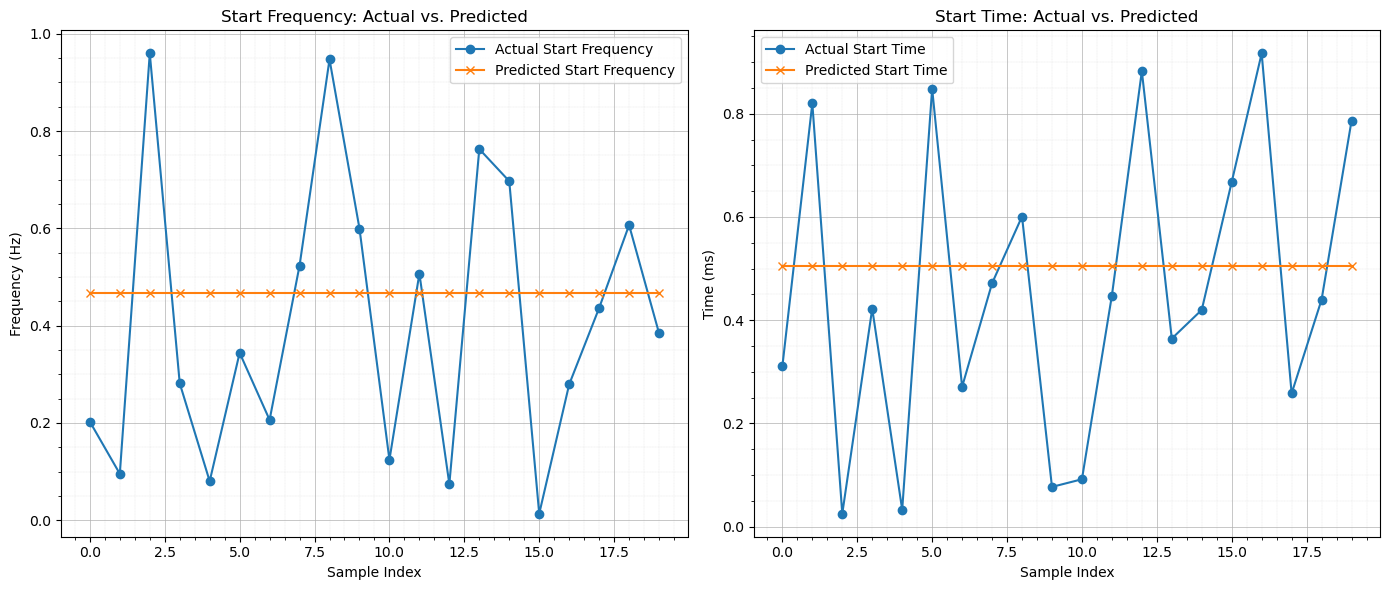

In [18]:
y_pred = model23.predict(X_test)

# Compare the predicted vs. actual values
# Number of samples to display
n = 20 
# Simple index array
t = np.arange(n)

plt.figure(figsize=(14, 6))

# Plot actual vs. predicted for start frequency
plt.subplot(1, 2, 1)
plt.plot(t, y_test[:n, 0], 'o-', label='Actual Start Frequency')
plt.plot(t, y_pred[:n, 0], 'x-', label='Predicted Start Frequency')
plt.title('Start Frequency: Actual vs. Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.tight_layout()

# Plot actual vs. predicted for start time
plt.subplot(1, 2, 2)
plt.plot(t, y_test[:n, 1], 'o-', label='Actual Start Time')
plt.plot(t, y_pred[:n, 1], 'x-', label='Predicted Start Time')
plt.title('Start Time: Actual vs. Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Time (ms)')
plt.legend()
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.tight_layout()
plt.show()

# Task 3

## Model
- This model takes data from both the spectrogram and time-series data files in order to make predictions on the start times and frequencies of chirps. 
- This model takes around 15 mins to run. Please be patient again.

In [19]:
# Load the data
spectrogram = np.load('cresSpect8.npy')
time_series = np.load('cresWave8.npy')
metadata = pd.read_csv('cresSpectMeta8.csv')

# Normalise the data
scaler_spect = MinMaxScaler(feature_range=(0, 1))
spectrogram_normalized = scaler_spect.fit_transform(spectrogram.reshape(-1, spectrogram.shape[1]*spectrogram.shape[2])).reshape(-1, spectrogram.shape[1], spectrogram.shape[2], 1)
scaler_ts = MinMaxScaler(feature_range=(0, 1))
time_series_normalized = scaler_ts.fit_transform(time_series.reshape(-1, time_series.shape[1])).reshape(-1, time_series.shape[1], 1)
targets = metadata[['t0s', 'f0s']].values
scaler_y = MinMaxScaler(feature_range=(0, 1))
targets_normalized = scaler_y.fit_transform(targets)

# Split the dataset
X_train_spect, X_test_spect, X_train_ts, X_test_ts, y_train, y_test = train_test_split(
    spectrogram_normalized, time_series_normalized, targets_normalized, test_size=0.2, random_state=42)

# Building
input_spect = Input(shape=(spectrogram.shape[1], spectrogram.shape[2], 1))
x = Conv2D(24, (3, 3), activation='relu', padding='same')(input_spect) 
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

input_ts = Input(shape=(time_series.shape[1], 1))
y = Conv1D(24, 3, activation='relu', padding='same')(input_ts) 
y = MaxPooling1D(2)(y)
y = BatchNormalization()(y)
y = GlobalAveragePooling1D()(y)

combined = concatenate([x, y])
z = Dense(32, activation='relu')(combined)
z = Dropout(0.3)(z)
z = BatchNormalization()(z)
output = Dense(2, activation='linear')(z)

model3 = Model(inputs=[input_spect, input_ts], outputs=output)

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Setup a learning rate reducer
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history3 = model3.fit([X_train_spect, X_train_ts], y_train, validation_data=([X_test_spect, X_test_ts], y_test), 
                    epochs=25, batch_size=32, callbacks=[reduce_lr])

Epoch 1/25
25/25 [==============================] - 20s 740ms/step - loss: 0.9688 - val_loss: 0.4015 - lr: 0.0010
Epoch 2/25
25/25 [==============================] - 696s 805ms/step - loss: 0.5094 - val_loss: 0.2384 - lr: 0.0010
Epoch 3/25
25/25 [==============================] - 18s 699ms/step - loss: 0.2698 - val_loss: 0.1560 - lr: 0.0010
Epoch 4/25
25/25 [==============================] - 19s 764ms/step - loss: 0.1451 - val_loss: 0.1139 - lr: 0.0010
Epoch 5/25
25/25 [==============================] - 20s 801ms/step - loss: 0.0933 - val_loss: 0.0965 - lr: 0.0010
Epoch 6/25
25/25 [==============================] - 17s 679ms/step - loss: 0.0861 - val_loss: 0.0887 - lr: 0.0010
Epoch 7/25
25/25 [==============================] - 17s 697ms/step - loss: 0.0846 - val_loss: 0.0870 - lr: 0.0010
Epoch 8/25
25/25 [==============================] - 17s 690ms/step - loss: 0.0844 - val_loss: 0.0860 - lr: 0.0010
Epoch 9/25
25/25 [==============================] - 18s 707ms/step - loss: 0.0844 - val

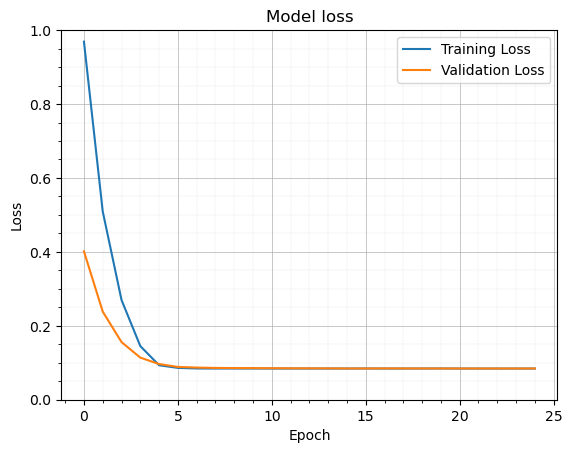

7/7 [==============================] - 1s 144ms/step
Time MSE: 0.08339882633560844
Frequency MSE: 0.08565596676294401


In [20]:
# Plotting training and validation loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.ylim(0, 1)
plt.show()

# predictions from the model
predictions = model3.predict([X_test_spect, X_test_ts])

# MSE for time predictions
time_true = y_test[:, 0] 
time_pred = predictions[:, 0]
time_mse = mean_squared_error(time_true, time_pred)

# MSE for frequency predictions
freq_true = y_test[:, 1]
freq_pred = predictions[:, 1]
freq_mse = mean_squared_error(freq_true, freq_pred)

# Print out MSE values
print(f'Time MSE: {time_mse}')
print(f'Frequency MSE: {freq_mse}')

## Predictions

1/1 [==============================] - 0s 14ms/step


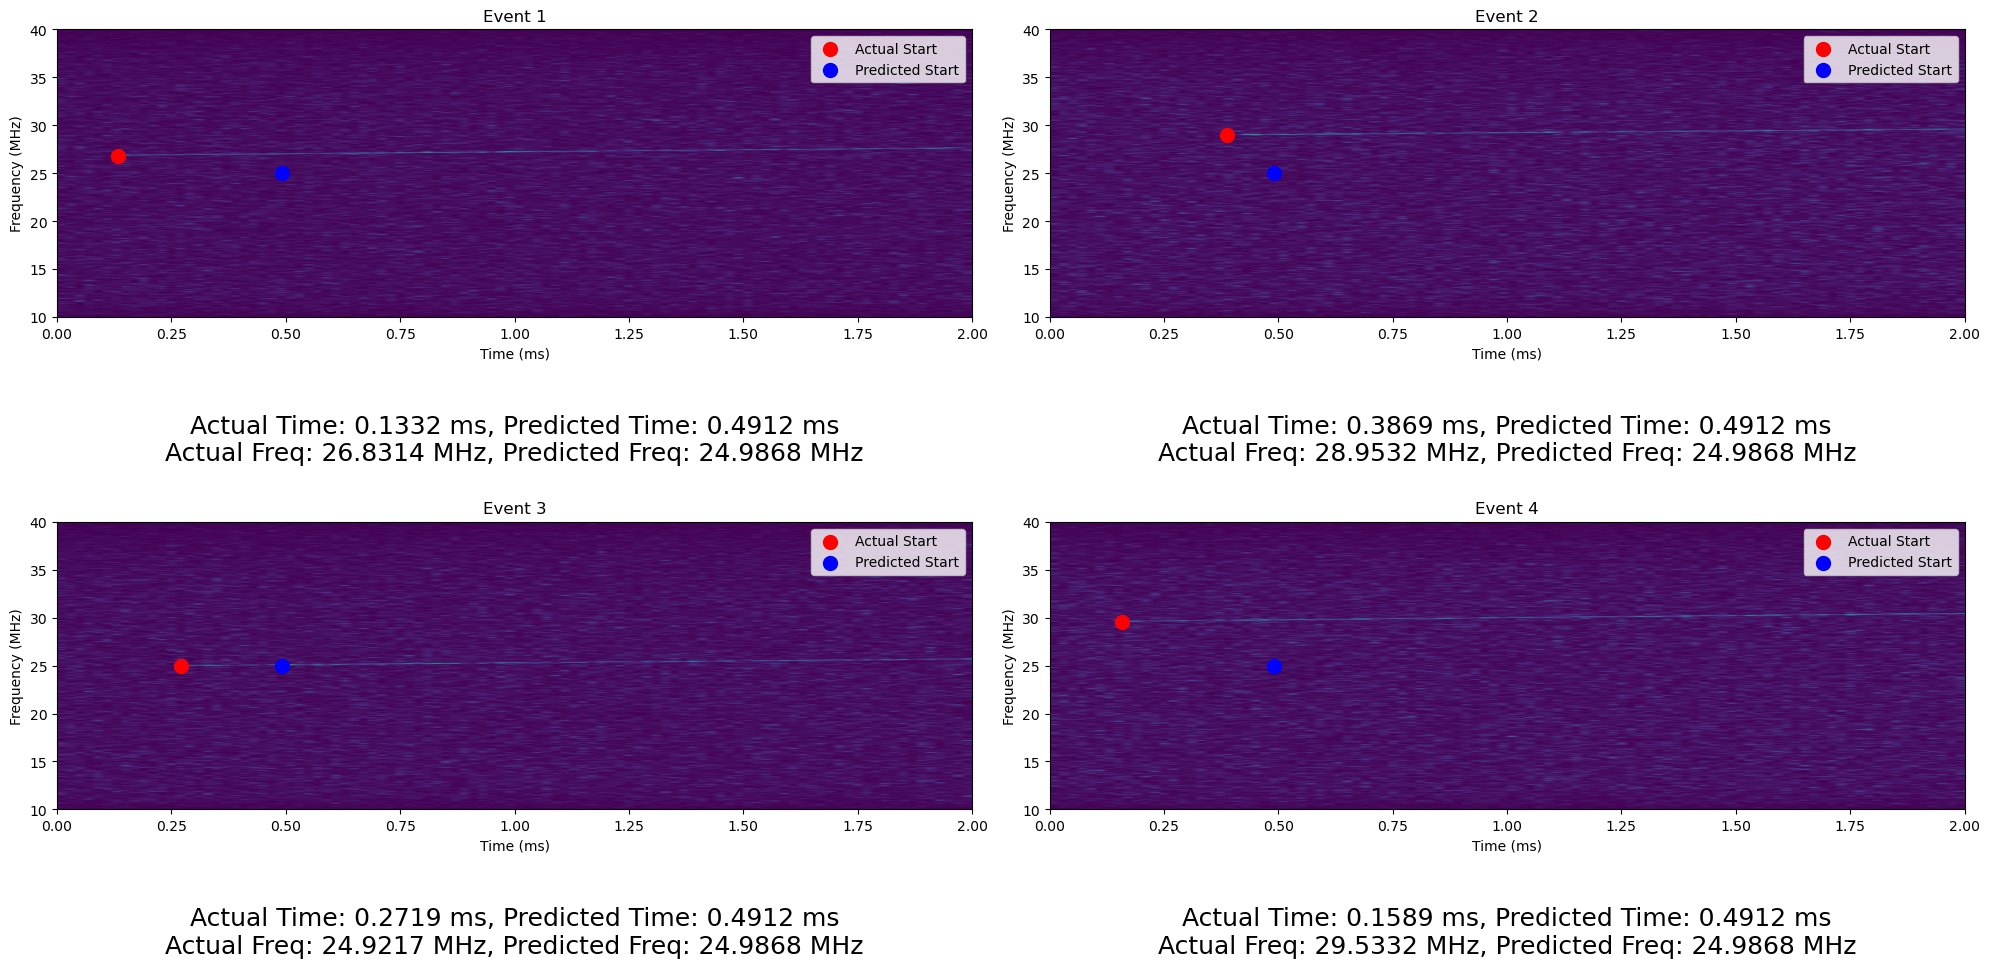

In [21]:
## Load and prepare training data for scaler fitting
spectrogram_train = np.load('cresSpect8.npy')
time_series_train = np.load('cresWave8.npy')
metadata_train = pd.read_csv('cresSpectMeta8.csv')
spectrogram_train_reshaped = spectrogram_train.reshape(-1, spectrogram_train.shape[1]*spectrogram_train.shape[2])
time_series_train_reshaped = time_series_train.reshape(-1, time_series_train.shape[1])
scaler_spect = MinMaxScaler()
scaler_ts = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_spect.fit(spectrogram_train_reshaped)
scaler_ts.fit(time_series_train_reshaped)
scaler_y.fit(metadata_train[['t0s', 'f0s']].values)

# Load datasets for prediction
spectrogram_new = np.load('cresSpect9.npy')
time_series_new = np.load('cresWave9.npy')
metadata_new = pd.read_csv('cresSpectMeta9.csv')
spectrogram_new_normalized = scaler_spect.transform(spectrogram_new.reshape(-1, spectrogram_new.shape[1]*spectrogram_new.shape[2])).reshape(-1, spectrogram_new.shape[1], spectrogram_new.shape[2], 1)
time_series_new_normalized = scaler_ts.transform(time_series_new.reshape(-1, time_series_new.shape[1])).reshape(-1, time_series_new.shape[1], 1)

# Prepare subplot grid
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

# Predict and plot for each event
for i in range(len(metadata_new)):
    spect_to_predict = spectrogram_new_normalized[i].reshape(1, *spectrogram_new.shape[1:3], 1)
    ts_to_predict = time_series_new_normalized[i].reshape(1, time_series_new.shape[1], 1)
    prediction = model3.predict([spect_to_predict, ts_to_predict])
    raw_predicted_t0s_rescaled, raw_predicted_f0s_rescaled = scaler_y.inverse_transform(prediction).flatten()

    predicted_t0s_rescaled = raw_predicted_t0s_rescaled * 1e3
    predicted_f0s_rescaled = raw_predicted_f0s_rescaled / 1e6
    
    # Converting to milliseconds
    actual_t0s = metadata_new.iloc[i]['t0s'] * 1e3
    
    # Converting to MHz
    actual_f0s = metadata_new.iloc[i]['f0s'] / 1e6  

    # Plotting
    axs[i].imshow(spectrogram_new[i], extent=[0, 2, 10, 40], aspect='auto', origin='lower')
    axs[i].scatter(actual_t0s, actual_f0s, color='red', s=100, label='Actual Start')
    axs[i].scatter(predicted_t0s_rescaled, predicted_f0s_rescaled, color='blue', s=100, label='Predicted Start')
    axs[i].set_title(f'Event {i+1}')
    axs[i].set_xlabel("Time (ms)")
    axs[i].set_ylabel("Frequency (MHz)")
    axs[i].text(1, -0.1, f'Actual Time: {actual_t0s:.4f} ms, Predicted Time: {predicted_t0s_rescaled:.4f} ms\nActual Freq: {actual_f0s:.4f} MHz, Predicted Freq: {predicted_f0s_rescaled:.4f} MHz', ha='center', va='top', fontsize=18)
    
    axs[i].legend()

    if i >= 3:  # plot for 4 events
        break

plt.tight_layout()
plt.show()


## How does the frequency resolution (e.g. the difference or standard deviation of measured frequency - true frequency from the meta data) depends on the simulated noise temperature or chrip 'slope'?

#### Frequency Resolution:
In Cyclotron Radiation Emission Spectroscopy (CRES), crucial for neutrino mass measurements, frequency resolution is a key parameter. It measures the system's ability to distinguish between two closely spaced frequency signals, which is vital for accurately identifying the cyclotron radiation emitted by neutrinos. The theoretical foundation of frequency resolution is shown by the inverse relationship with the measurement duration:

$$\Delta f = \frac{1}{T}$$

Where Δf is the frequency resolution and T is the observation time. This relationship highlights the inverse correlation between measurement duration and frequency resolution, showing the importance of longer observation times for finer resolution. However, this simple relationship is complicated by the system's response to noise and the signal's characteristics.

#### Impact of Simulated Noise Temperature:
Noise temperature in CRES experiments indicates the level of internal and external noise, measured in terms of power per unit bandwidth, which impacts the signal-to-noise ratio (SNR). Higher noise temperatures suggest increased background noise, possibly obscuring the cyclotron radiation signals from neutrinos. This effect can diminish the system's frequency resolution capability by blending the characteristics of the signals into the surrounding noise. The SNR, essential for effective signal detection and frequency resolution, is defined as:

$$ \text{SNR} = \frac{Ps}{Pn}$$

Where Ps and Pn represent the power of the signal and noise, respectively, with the latter being influenced by the noise temperature.

#### Chirp Signals in CRES for Neutrino Observations:
CRES involves analysing chirp signals, through variations in the frequency and phase of cyclotron radiation, to determine neutrino masses. These chirp signals reflect the energy and movement of the neutrinos, making the chirp slope (rate of frequency change) a critical factor. The chirp slope aids in distinguishing between the start times and frequencies of these signals, essential for accurate neutrino mass measurements:

$$ S = \frac{\Delta f}{T}$$

Where S is the chirp slope or rate, Δf is the change in frequency, and T is the chirp's duration.

#### Advanced Signal Processing in CRES:
CRES uses modern signal processing techniques, such as Fast Fourier Transforms (FFT), to study the frequency components of cyclotron radiation. The resolution of closely spaced frequencies by FFT is determined by the observation time, noise characteristics, and signal processing procedures. Optimising FFT, adjusted to expected noise levels and cyclotron radiation properties, is critical for increasing frequency resolution.


#### Integrating CRES into Neutrino Mass Measurements:
Improving frequency resolution in CRES, particularly for neutrino mass measurements, necessitates comprehensive techniques that address measurement timeframes, noise avoidance, and advanced signal processing algorithms. These efforts are intended to increase SNR and improve the system's capacity to discern distinct cyclotron frequencies, which reflect different neutrino energy states. Accurate frequency resolution is essential for neutrino mass measurements because it allows accurate distinctions between neutrino kinds and energy levels, providing important insights into fundamental particle physics.



# Workbook Conclusion:

In essence, this workbook answers all three tasks as required and provides alternative solutions to where the faulty data has hindered model capabilties. Task 1 sees a competitive accuracy in its ability to predict both frequency and temporal related aspects of the chirps, it's ability to learn quickly is also admirable. Task 2 demonstrates the issues that one will come across when using poor quality data (with high noise). The attached report delves into the depths of the outcomes of this file. 